In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import os
from mnist_web import mnist

train_images, train_labels, test_images, test_labels = mnist(path=os.path.join(os.getcwd(), "mnist"))

X_train = torch.from_numpy(train_images).float().to(device)
y_train = torch.from_numpy(train_labels).int().to(device)
X_test = torch.from_numpy(test_images).float().to(device)
y_test = torch.from_numpy(test_labels).int().to(device)

In [4]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(784, 100, bias=True)
        self.fc2 = nn.Linear(100, 100, bias=True)
        self.fc3 = nn.Linear(100, 100, bias=True)
        self.fc4 = nn.Linear(100, 10, bias=True)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.relu(self.fc3(X))
        X = self.log_softmax(self.fc4(X))
        return X

In [6]:
model = Neural_Network().to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 100

# Train step
model.train()

for i in range(epochs):

    optimizer.zero_grad()

    y_train_ = model(X_train)

    loss = loss_fn(y_train_, torch.max(y_train, 1)[1])
    
    if ((i + 1) % 10) == 0:
        print(f"Epoch {i + 1}: {loss}")

    loss.backward()
    optimizer.step() 
    
print(f"Loss after {epochs} epochs: {loss}")

Epoch 10: 2.283947706222534
Epoch 20: 2.157139301300049
Epoch 30: 1.2954695224761963
Epoch 40: 2.7711191177368164
Epoch 50: 1.414258599281311
Epoch 60: 0.8224509954452515
Epoch 70: 0.5260645151138306
Epoch 80: 0.40042412281036377
Epoch 90: 0.33220481872558594
Epoch 100: 0.2870043218135834
Loss after 100 epochs: 0.2870043218135834


Test Accuracy: 0.9176


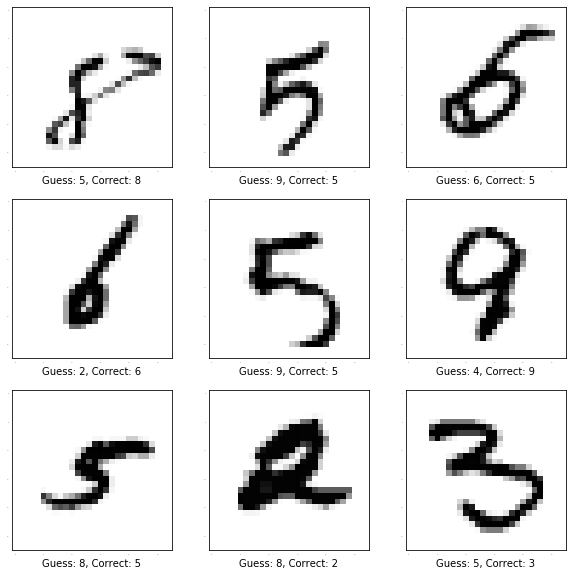

In [7]:
# Eval
model.eval()

with torch.no_grad():
    y_test_ = model(X_test)  

correct = []
incorrect = []

num_datapoints = y_test.shape[0]

for i in range(num_datapoints):
    if torch.argmax(y_test[i]) == torch.argmax(y_test_[i]):
        correct.append(i)
    else:
        incorrect.append(i)
    
print("Test Accuracy:", len(correct) / num_datapoints)

# plot some incorrect testing examples
if len(incorrect) >= 9:
    X_incorrect = X_test[incorrect].cpu()
    y_incorrect = model.forward(X_incorrect.to(device)).cpu()
    incorrect_labels = torch.argmax(y_incorrect, 1)
    correct_labels = torch.argmax(y_test[incorrect], 1)

    from random import sample
    
    examples = sample(range(len(incorrect)), 9)

    plt.figure(figsize=(10,10))
    for i in range(9):
        index = examples[i]
        plt.subplot(3,3,i+1)
        plt.tick_params(axis='both', labelsize=0, length=0)
        plt.grid(False)
        plt.imshow(X_incorrect[index].reshape((28,28)), cmap='Greys')
        label = f"Guess: {incorrect_labels[index]}, Correct: {correct_labels[index]}"
        plt.xlabel(label)
    plt.show()